In [1]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import os
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions


Using TensorFlow backend.


In [2]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def get_data():
    train = load_from('../data/interim/train.pkl')
    val = load_from('../data/interim/val.pkl')
    test = load_from('../data/interim/test.pkl')

    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_datagen(data, set_name, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_dataframe(dataframe=data,
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='target', 
                                            target_size=(img_height, img_width),
                                            classes=['fine', 'beautiful'],
                                            class_mode='categorical', 
                                            batch_size=batch_size)
    return generator


def load_model(name):
    model_path = f'../models/{name}/'

    # Model reconstruction from JSON file
    with open(model_path + 'model.json', 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(model_path + 'model_weights.h5')
    return model

In [4]:
path = '../models/'
models = list(os.listdir(path))
sorted(models)

['.gitkeep',
 'logs',
 'output',
 'xception_20190604_2351',
 'xception_L106_drop0.5_sgd-0.0001-decay0.05_',
 'xception_L106_drop0.5_sgd-0.0001_',
 'xception_L106_drop0.5_sgd-0.0005-decay0.0001_',
 'xception_L106_drop0.5_sgd-0.0005-decay0.05_',
 'xception_L106_drop0.5_sgd-0.0005_',
 'xception_L106_drop0.5_sgd-0.0008-decay0.0001_',
 'xception_L106_drop0.5_sgd-0.001-decay0.05_',
 'xception_L106_drop0.5_sgd-0.001_',
 'xception_L106_drop0.6_sgd-0.0001_',
 'xception_L106_drop0.6_sgd-0.0005_',
 'xception_L106_drop0.6_sgd-0.001_',
 'xception_L106_drop0.6_sgd-0.005_',
 'xception_L106_drop0.6_sgd-0.008_',
 'xception_L116_drop0.5_sgd-0.001_',
 'xception_L116_drop0.6_sgd-0.0001_',
 'xception_L116_drop0.6_sgd-0.0005_',
 'xception_L116_drop0.6_sgd-0.001_',
 'xception_L126_drop0.6_sgd-0.0001_',
 'xception_L126_drop0.6_sgd-0.0005_',
 'xception_L126_drop0.6_sgd-0.001_',
 'xception_L96_drop0.6_sgd-0.0001_',
 'xception_L96_drop0.6_sgd-0.0005_',
 'xception_L96_drop0.6_sgd-0.001_',
 'xception_L96_drop0.6_s

In [5]:
top_models = [
    'xception_L106_drop0.6_sgd-0.0001_',
    'xception_L96_drop0.6_sgd-0.0001_',
    'xception_L106_drop0.6_sgd-0.005_',
    'xception_L116_drop0.5_sgd-0.001_',
]

In [6]:
model = load_model(top_models[0])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [60]:
img_height, img_width = (237, 1820)
batch_size = 32

train, val, test = get_data()

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.



In [16]:
train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)
test_generator = get_datagen(test, 'test', img_height, img_width, batch_size)

train_generator.reset()
val_generator.reset()
test_generator.reset()

train_preds = model.predict_generator(
    train_generator, 
    steps=np.ceil(len(train) / batch_size),
    verbose=1,
    use_multiprocessing=True
)

val_preds = model.predict_generator(
    val_generator, 
    steps=np.ceil(len(train) / batch_size),
    verbose=1,
    use_multiprocessing=True
)

test_preds = model.predict_generator(
    test_generator, 
    steps=np.ceil(len(train) / batch_size),
    verbose=1,
    use_multiprocessing=True
)

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2056 images with 46.89% positive class.
Val set has 514 images with 50.78% positive class.
Test set has 643 images with 47.12% positive class.

Found 2056 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
65/65 [==============================] - 189s 3s/step


In [72]:
preds = [train_preds, val_preds, test_preds]
for pred in preds:
    print(len(pred))

2056
1990
1993


In [71]:
len(train_preds)

2056

In [61]:
df = pd.DataFrame(train_preds)
classes = train_generator.class_indices
i_beauty = classes['beautiful']
i_fine = classes['fine']
cols = classes.keys()
df.columns = cols
theshhold = 0.5
pred = lambda x: 1 if x[i_beauty] > 0.5 else 0
pred_class = lambda x: 'beautiful' if x[i_beauty] > 0.5 else 'fine'
df['pred'] = df.apply(pred, axis=1)
df['pred_class'] = df.apply(pred_class, axis=1)
df.head()

,beautiful,fine,pred,pred_class
0,0.579994,0.420006,1,beautiful
1,0.290778,0.709222,0,fine
2,0.628264,0.371736,1,beautiful
3,0.416915,0.583085,0,fine
4,0.279730,0.720270,0,fine


In [68]:
train_generator.filenames

['201708021320thumb.jpg',
 '201705150540thumb.jpg',
 '201707302040thumb.jpg',
 '201810150620thumb.jpg',
 '201809221530thumb.jpg',
 '201809290800thumb.jpg',
 '201903241350thumb.jpg',
 '201707192020thumb.jpg',
 '201903060610thumb.jpg',
 '201812030810thumb.jpg',
 '201502190850thumb.jpg',
 '201811051020thumb.jpg',
 '201809050930thumb.jpg',
 '201704161500thumb.jpg',
 '201708051550thumb.jpg',
 '201508010730thumb.jpg',
 '201807190500thumb.jpg',
 '201807290830thumb.jpg',
 '201803160830thumb.jpg',
 '201711080600thumb.jpg',
 '201609200830thumb.jpg',
 '201810251510thumb.jpg',
 '201802040950thumb.jpg',
 '201708291750thumb.jpg',
 '201708291930thumb.jpg',
 '201710221750thumb.jpg',
 '201810301820thumb.jpg',
 '201808111710thumb.jpg',
 '201812131230thumb.jpg',
 '201607102050thumb.jpg',
 '201810170920thumb.jpg',
 '201901071200thumb.jpg',
 '201809171310thumb.jpg',
 '201607030624thumb.jpg',
 '201604161330thumb.jpg',
 '201710011440thumb.jpg',
 '201712221220thumb.jpg',
 '201501101230thumb.jpg',
 '2016060514

In [62]:
train_res = train.reset_index()
train_res[['beauty_prob', 'pred', 'pred_class']] = df[['beautiful', 'pred', 'pred_class']]
train_res.head()

,date,filepath,score,matches,filename,target,beauty_prob,pred,pred_class
0,2017-08-02 13:20:00,2017/08/02/2017_0802_132000/thumbnail.jpg,0,2,201708021320thumb.jpg,fine,0.579994,1,beautiful
1,2017-05-15 05:40:00,2017/05/15/2017_0515_054000/thumbnail.jpg,1,2,201705150540thumb.jpg,beautiful,0.290778,0,fine
2,2017-07-30 20:40:00,2017/07/30/2017_0730_204000/thumbnail.jpg,1,1,201707302040thumb.jpg,beautiful,0.628264,1,beautiful
3,2018-10-15 06:20:00,2018/10/15/2018_1015_062000/thumbnail.jpg,0,2,201810150620thumb.jpg,fine,0.416915,0,fine
4,2018-09-22 15:30:00,2018/09/22/2018_0922_153000/thumbnail.jpg,1,2,201809221530thumb.jpg,beautiful,0.279730,0,fine


Confusion matrix, without normalization
[[619 473]
 [557 407]]
Normalized confusion matrix
[[0.57 0.43]
 [0.58 0.42]]


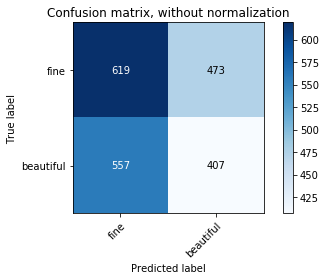

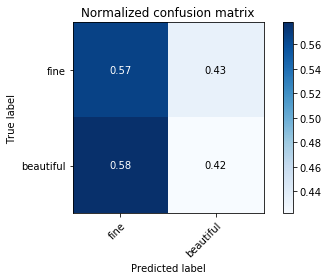

In [67]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# class_names = iris.target_names

# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.25
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

y_test = train_res['score']
y_pred = train_res['pred']
class_names = train_res['target']


# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [69]:
train_res.sort_values(by='beauty_prob')

,date,filepath,score,matches,filename,target,beauty_prob,pred,pred_class
1037,2017-07-28 16:00:00,2017/07/28/2017_0728_160000/thumbnail.jpg,1,2,201707281600thumb.jpg,beautiful,0.010241,0,fine
1386,2017-10-28 09:30:00,2017/10/28/2017_1028_093000/thumbnail.jpg,1,1,201710280930thumb.jpg,beautiful,0.012661,0,fine
480,2017-08-09 06:50:00,2017/08/09/2017_0809_065000/thumbnail.jpg,1,2,201708090650thumb.jpg,beautiful,0.014395,0,fine
1836,2015-04-10 14:10:00,2015/04/10/2015_0410_141000/thumbnail.jpg,0,2,201504101410thumb.jpg,fine,0.015981,0,fine
12,2018-09-05 09:30:00,2018/09/05/2018_0905_093000/thumbnail.jpg,1,1,201809050930thumb.jpg,beautiful,0.016187,0,fine
1742,2018-07-14 06:40:00,2018/07/14/2018_0714_064000/thumbnail.jpg,1,2,201807140640thumb.jpg,beautiful,0.016962,0,fine
1334,2017-08-22 05:20:00,2017/08/22/2017_0822_052000/thumbnail.jpg,0,2,201708220520thumb.jpg,fine,0.016987,0,fine
1168,2018-08-01 08:50:00,2018/08/01/2018_0801_085000/thumbnail.jpg,0,2,201808010850thumb.jpg,fine,0.017506,0,fine
1028,2015-06-18 12:00:00,2015/06/18/2015_0618_120000/thumbnail.jpg,0,2,201506181200thumb.jpg,fine,0.017674,0,fine
479,2018-07-10 09:20:00,2018/07/10/2018_0710_092000/thumbnail.jpg,0,2,201807100920thumb.jpg,fine,0.017700,0,fine


In [ ]:
train_preds.